### Modeling for trivia questions exploration

##### In this notebook, we will finetune T5 on trivia dataset.

##### T5 [(Text-To-Text Transfer Transformer)](https://ai.googleblog.com/2020/02/exploring-transfer-learning-with-t5.html) model is for all practical purposes the original Transformer model trained on a new dataset called Colossal Clean Crawled Corpus, aka C4.

##### Information about Trivia dataset used: http://nlp.cs.washington.edu/triviaqa/

- I will accessing trivia_qa through HuggingFace Datasets
- But Tensorflow page has better documentation about the dataset arguments: https://www.tensorflow.org/datasets/catalog/trivia_qa
- Use this script to evaluate: https://github.com/mandarjoshi90/triviaqa/blob/master/evaluation/triviaqa_evaluation.py
- State of the art F1 scores tracked here: https://competitions.codalab.org/competitions/17208


##### Some relevant text from [HuggingFace](https://huggingface.co/transformers/model_doc/t5.html#overview):
- T5 is an encoder-decoder model pre-trained on a multi-task mixture of unsupervised and supervised tasks and for which each task is converted into a text-to-text format. T5 works well on a variety of tasks out-of-the-box by prepending a different prefix to the input corresponding to each task, e.g., for translation: translate English to German: …, for summarization: summarize: ….

- For sequence-to-sequence generation, it is recommended to use T5ForConditionalGeneration.generate(). This method takes care of feeding the encoded input via cross-attention layers to the decoder and auto-regressively generates the decoder output.

## 0. Installations

In [ ]:
!pip install transformers
!pip install datasets   # https://github.com/huggingface/datasets
!pip install pytorch-lightning # better nn.Module

In [159]:
import torch
import pytorch_lightning as pl

import random
import numpy as np
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    T5Config,
    AdamW, 
    Adafactor,
    get_linear_schedule_with_warmup
)
import json
import os
import re

from datasets import (
    list_datasets,
    load_dataset,
    list_metrics,
    load_metric)

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler

import matplotlib.pyplot as plt

## Colab accessing Google drive
from google.colab import drive

In [154]:
model_name_or_path='t5-base'
tokenizer_name_or_path='t5-base'

In [155]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### **`from transformers import` Notes**
- Import tokenizer for formatting input text. Has to be model's because we are finetuning it. Or, use `AutoTokenizer` to pick the right one.
- T5ForConditionalGeneration: actual model that we need to finetune
- Model specific config that has model specific data like vocab_size, size of encoder layers, etc.
- [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw-pytorch): one kind of Adam
- [Adafactor](https://www.paperswithcode.com/method/adafactor): another kind of Adam that reduces memory. :D

In [156]:
list_datasets()

['acronym_identification',
 'ade_corpus_v2',
 'adversarial_qa',
 'aeslc',
 'afrikaans_ner_corpus',
 'ag_news',
 'ai2_arc',
 'air_dialogue',
 'ajgt_twitter_ar',
 'allegro_reviews',
 'allocine',
 'alt',
 'amazon_polarity',
 'amazon_reviews_multi',
 'amazon_us_reviews',
 'ambig_qa',
 'amttl',
 'anli',
 'app_reviews',
 'aqua_rat',
 'aquamuse',
 'ar_cov19',
 'ar_res_reviews',
 'ar_sarcasm',
 'arabic_billion_words',
 'arabic_pos_dialect',
 'arabic_speech_corpus',
 'arcd',
 'arsentd_lev',
 'art',
 'arxiv_dataset',
 'aslg_pc12',
 'asnq',
 'asset',
 'assin',
 'assin2',
 'atomic',
 'autshumato',
 'babi_qa',
 'banking77',
 'bbc_hindi_nli',
 'bc2gm_corpus',
 'best2009',
 'bianet',
 'bible_para',
 'big_patent',
 'billsum',
 'bing_coronavirus_query_set',
 'biomrc',
 'blended_skill_talk',
 'blimp',
 'blog_authorship_corpus',
 'bn_hate_speech',
 'bookcorpus',
 'bookcorpusopen',
 'boolq',
 'bprec',
 'break_data',
 'brwac',
 'bsd_ja_en',
 'bswac',
 'c3',
 'c4',
 'cail2018',
 'caner',
 'capes',
 'catalon

In [157]:
dataset = load_dataset('trivia_qa', 'rc.nocontext') # Possible kwargs: ['rc', 'rc.nocontext', 'unfiltered', 'unfiltered.nocontext'] 

Reusing dataset trivia_qa (/root/.cache/huggingface/datasets/trivia_qa/rc.nocontext/1.1.0/9977a5d6f72acfd92f587de052403e8138b43bb0d1ce595016c3baf7e14deba6)


## 1. Understanding dataset

In [ ]:
dataset

In [ ]:
dataset['train'][10]

In [12]:
q_len, ans_len = [], []
for row in dataset['train']:
    q = row['question'].replace('\n', '')
    q_words = q.split()
    ans = row['answer']['value'].replace('\n', '')
    ans_words = ans.split()
    q_len.append(len(q_words))
    ans_len.append(len(ans_words))

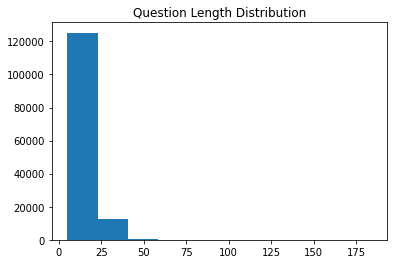

In [13]:
%matplotlib inline
plt.hist(q_len)
plt.title('Question Length Distribution')
plt.show()

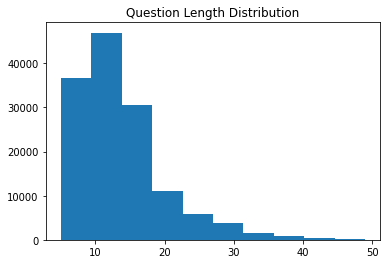

In [11]:
plt.hist([q for q in q_len if q < 50])
plt.title('Question Length Distribution')
plt.show()

In [12]:
print("Average length of question: ", sum(q_len)/len(q_len))
print("Average length of answer: ", sum(ans_len)/len(ans_len))

Average length of question:  13.796818996415771
Average length of answer:  1.6840169383743786


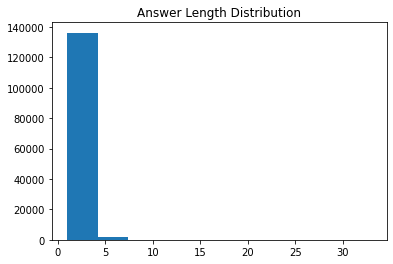

In [13]:
plt.hist(ans_len)
plt.title('Answer Length Distribution')
plt.show()

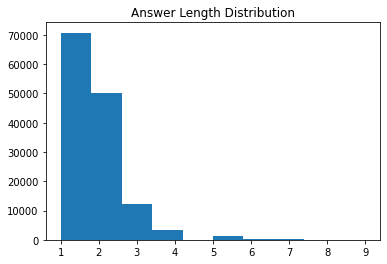

In [14]:
plt.hist([a for a in ans_len if a < 10])
plt.title('Answer Length Distribution')
plt.show()

In [15]:
print(len([a for a in ans_len if a < 5]))
print(len(ans_len))

136245
138384


In [16]:
count = 0
for row in dataset['train']:
    ans = row['answer']['value'].replace('\n', '')
    ans_words = ans.split()
    if len(ans_words) > 20:
        count += 1
        print(row['question'])
        print(ans)
        print("--------")
    if count == 8:
        break

What baseball player hit the only home run of his 212-year major league career off his own brother?
Joe Nickro in 1976. Nickro, a pitcher with the Houston Astros, hit a four-bagger off his brother Phil, who was pitching fro the Atlanta Braves. Houston won the game, 4-3
--------
Brooks Robinson and Carl Yastrzemski hold the major league baseball record for playing the greatest number of seasons with the same team. How many years did they play-- and with what teams?
23 years. Third baseman Robinson played with the Baltimore Orioles from 1955 to 1977; Carl Yastrzemski, outfielder/first baseman, played with the Boston Red Sox from 1961 to 1983
--------
If Tony Blackburn won in 2002, Phil Tuffnell won in 2003, and Kerry Katona won in 2004, who won in 2007?
Christopher Biggins. (I'm a Celebrity, Get Me Out of Here. Joe Pasquale 04, Carol Thatcher 05, Matt Willis 06, and Joe Swash 08).
--------
What three important things should be confirmed and understood before conducting a brainstorming id

In [17]:
print(len([q for q in q_len if q < 50]))
print(len(q_len))

138147
138384


In [18]:
count = 0
for row in dataset['train']:
    q = row['question'].replace('\n', '')
    q_words = q.split()
    if len(q_words) > 20:
        count += 1
        print(q)
    if count == 8:
        break

Brooks Robinson and Carl Yastrzemski hold the major league baseball record for playing the greatest number of seasons with the same team. How many years did they play-- and with what teams?
Under the rules outlined in the charter of the International Olympic Committee, how much pure gold must there be in each gold medal awarded to first-place winners?
What popular drink did a Dutch medical professor produce in his laboratory while trying to come up with a blood cleanser that could be sold in drugstores?
What writer was expelled from West Point for showing up for a public parade wearing only a white belt and gloves?
"Psychologist William Moulton Marston, inventor of the polygraph, or lie detector, also created a famous comic book heroine,. Who was she?"""
What was the name of the she-ape that rescued the infant Tarzan and raised him to be Lord of the Apes?
What was the original name of the orphan created in 1924 by cartoonist Harold Gray in the comic strip we know as Little Orphan Annie

In [14]:
clean_train_dataset = dataset['train'].filter(lambda x: len(x['answer']['value'].replace('\n', '').split()) < 5 
                                              and len(x['question'].replace('\n', '').split()) < 50)

In [15]:
clean_train_dataset

Dataset({
    features: ['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer'],
    num_rows: 136018
})

In [16]:
count = 0
for example in clean_train_dataset:
    print(example['question'], example['answer']['value'])
    count += 1
    if count == 30:
        break

Which American-born Sinclair won the Nobel Prize for Literature in 1930? Sinclair Lewis
Where in England was Dame Judi Dench born? York
In which decade did Billboard magazine first publish and American hit chart? 30s
From which country did Angola achieve independence in 1975? Portugal
Which city does David Soul come from? Chicago
Who won Super Bowl XX? Chicago Bears
Which was the first European country to abolish capital punishment? Norway
In which country did he widespread use of ISDN begin in 1988? Japan
What is Bruce Willis' real first name? Walter
Which William wrote the novel Lord Of The Flies? Golding
Which innovation for the car was developed by Prince Henry of Prussia in 1911? Windshield wipers
How is musician William Lee Conley better known? Big Bill Broonzy
How is Joan Molinsky better known? Joan Rivers
In which branch of the arts is Patricia Neary famous? Ballet
Which country is Europe's largest silk producer? Italy
The VS-300 was a type of what? Helicopter
At which universi

## 2. Preprocessing the training data

In [17]:
import transformers
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

#!pip install sentencepiece ## required by T5Tokenizer only
# tokenizer = T5Tokenizer.from_pretrained(tokenizer_name_or_path)

In [18]:
print(tokenizer)

PreTrainedTokenizerFast(name_or_path='t5-base', vocab_size=32100, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<extra_id_43>', '<extra_id_44>', '<extra_id_45

In [19]:
tokenizer("What is your name?", "My name is Sylvain.")

{'input_ids': [363, 19, 39, 564, 58, 1, 499, 564, 19, 5224, 40, 900, 77, 5, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [20]:
max_len = 0
len_all = []
for i, example in enumerate(clean_train_dataset):
    len_all.append(len(tokenizer(example['question'], example['answer']['value'])["input_ids"]))

print("avg token len: ", sum(len_all)/len(len_all))
print("max len: ", max(len_all))

avg token len:  25.453653192959756
max len:  148


In [21]:
max_length = 150        # I might truncate later. But going to keep the whole thing for now
doc_stride = 50         # The authorized overlap between parts of context when splitting is needed.

tokenized_example = tokenizer(
    clean_train_dataset[20]['question'],
    clean_train_dataset[20]['answer']['value'],
    max_length = max_length,
    truncation = "only_first",  ## these params wont be used for now.
    return_overflowing_tokens = True,
    stride = doc_stride
)

tokenized_example

{'input_ids': [[2645, 47, 8, 163, 25727, 11874, 59, 12, 43, 3, 9, 2214, 564, 58, 1, 13995, 107, 25727, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'overflow_to_sample_mapping': [0]}

In [121]:
def clean_text(text):
    text = text.replace('Example of text:', '')
    text = text.replace('Example of Summary:', '')
    text = text.replace('\n','')
    text = text.replace('``', '')
    text = text.replace('"', '')

    return text

max_length_input = 150
max_length_output = 50

def preprocess_function(examples):
    inputs = [clean_text(doc) for doc in examples['question']]
    model_inputs = tokenizer(inputs,
                             max_length = max_length_input,
                             padding = 'max_length',
                             truncation = "only_first")
    
    with tokenizer.as_target_tokenizer():
        outputs = [clean_text(doc['value']) for doc in examples['answer']]
        labels = tokenizer(outputs,
                           max_length = max_length_output,
                           padding = 'max_length',
                           truncation = "only_first")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [123]:
tokenized_datasets = dataset.map(preprocess_function, batched = True)

In [217]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['answer', 'attention_mask', 'entity_pages', 'input_ids', 'labels', 'question', 'question_id', 'question_source', 'search_results'],
        num_rows: 138384
    })
    validation: Dataset({
        features: ['answer', 'attention_mask', 'entity_pages', 'input_ids', 'labels', 'question', 'question_id', 'question_source', 'search_results'],
        num_rows: 18669
    })
    test: Dataset({
        features: ['answer', 'attention_mask', 'entity_pages', 'input_ids', 'labels', 'question', 'question_id', 'question_source', 'search_results'],
        num_rows: 17210
    })
})

In [218]:
from datasets import DatasetDict

num_samples = 100
rand_indices = np.random.choice(tokenized_datasets['train'].shape[0], num_samples, replace = False)
tokenized_datasets_subset = DatasetDict({'train': tokenized_datasets['train'].select(list(rand_indices)),
                                        'validation': tokenized_datasets['validation'].select(list(rand_indices)[:20]),
                                        'test': tokenized_datasets['test'].select(list(rand_indices)[:20])})

tokenized_datasets_subset

DatasetDict({
    train: Dataset({
        features: ['answer', 'attention_mask', 'entity_pages', 'input_ids', 'labels', 'question', 'question_id', 'question_source', 'search_results'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['answer', 'attention_mask', 'entity_pages', 'input_ids', 'labels', 'question', 'question_id', 'question_source', 'search_results'],
        num_rows: 20
    })
    test: Dataset({
        features: ['answer', 'attention_mask', 'entity_pages', 'input_ids', 'labels', 'question', 'question_id', 'question_source', 'search_results'],
        num_rows: 20
    })
})

## 3. Modeling!

In [22]:
## utils.py

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        return re.sub(r"\b(a|an|the)\b", " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def calculate_exact_match_score(prediction, ground_truth):
    return int(normalize_answer(prediction) == normalize_answer(ground_truth))


def calculate_approx_match_score(prediction, ground_truth):
    answer = normalize_answer(prediction) 
    gt = normalize_answer(ground_truth)
    match = 0
    gt_words = gt.split(" ")
    for word in gt_words:
        if word in answer:
            match = 1
            return match
    return match


def calculate_match_score(predictions, ground_truths):
    exact_match_score = 0
    subset_match_score = 0
    for i in range(len(predictions)):
        ground_truth = ground_truths[i]
        prediction = predictions[i]
        exact_match_score +=  calculate_exact_match_score(prediction, ground_truth)
        subset_match_score += calculate_approx_match_score(prediction, ground_truth)
    
    exact_match_score /= len(predictions)
    subset_match_score /= len(predictions)
    return exact_match_score*100, subset_match_score*100

###### Use Pytorch Lightening module: https://pytorch-lightning.readthedocs.io/en/1.2.3/common/lightning_module.html
###### Best bit to understand which function is called when: https://pytorch-lightning.readthedocs.io/en/1.2.3/common/lightning_module.html#hooks


In [198]:

class T5FineTuner(pl.LightningModule):

    def __init__(self, hparams):
        super(T5FineTuner, self).__init__()
        self.hparams = hparams
        self.model = T5ForConditionalGeneration.from_pretrained(hparams.tokenizer_name_or_path),
        self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
        self.model_dir = hparams.model_dir
        self.datasets = hparams.datasets


    ## Reference: https://huggingface.co/transformers/model_doc/t5.html#t5forconditionalgeneration
    def forward(self, input_ids, attention_mask, decoder_input_ids, labels):
        return self.model(
            input_ids,
            attention_mask = attention_mask,
            decoder_input_ids = decoder_input_ids,
            labels = labels
            )

    
    def training_step(self, batch, batch_idx):
        self.log('training step. Batch size: ', len(batch))
        labels = batch['labels']
        ## set padding token label to = -100 so that it is ignored
        labels[labels[:, :] == self.tokenizer.pad_token_id] = -100
        outputs = self.forward(
            input_ids = input_ids,
            attention_mask = attention_mask,
            decoder_input_ids = decoder_input_ids,
            labels = labels
        )
        loss = outputs[0]
        self.log('train_loss', loss, on_step = True, on_epoch = True, 
                 prog_bar = True, logger = True)
        return loss

    
    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log('epoch_avg_train_loss: ', avg_train_loss)
        return {'epoch_avg_train_loss': avg_train_loss, 'progress_bar': tensorboard_logs}


    def train_dataloader(self):
        train_dataset = self.datasets['train']
        sampler = RandomSampler(train_dataset)
        dataloader = DataLoader(train_dataset,
                                sampler = sampler,
                                batch_size = self.hparams.batch_size,
                                drop_last = True,
                                num_workers = 4)
        return dataloader


    def val_dataloader(self):
        validation_dataset = self.datasets['validation']
        sampler = RandomSampler(validation_dataset)
        return DataLoader(validation_dataset,
                          batch_size = self.hparams.eval_batch_size,
                          sampler = sampler,
                          num_workers = 4)
    

    def configure_optimizers(self):
        ## Set bias decay to zero
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.model[0].named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in self.model[0].named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },]
        optimizer = AdamW(optimizer_grouped_parameters, lr = self.hparams.learning_rate)
        # decreasing learning rate (linear) after increasing in num_warmup_steps
        scheduler = get_linear_schedule_with_warmup(
            optimizer = optimizer,
            num_warmup_steps = self.hparams.warmup_steps,
            num_training_steps = self.hparams.training_steps
        )
        self.lr_scheduler = scheduler
        self.log('configured optimizer: ', optimizer)
        return optimizer


    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None, using_native_amp=False):
        if self.trainer.use_tpu:
            xm.optimizer_step(optimizer)
        else:
            optimizer.step()
        optimizer.zero_grad()
        self.lr_scheduler.step()


    def validation_step(self, batch, batch_idx):
        t0 = time.time()

        generated_ids = self.model.generate(
            input_ids = batch['input_ids'],
            attention_mask = batch['attention_masks'],
            use_cache = True,
            max_length = max_length_output,
            num_beams = 2,
            early_stopping = True
        )
        # TODO (shikha): Might want to compare the ids itself
        predictions = self.ids_to_clean_text(generated_ids)
        targets = self.ids_to_clean_text(batch["target_input_ids"])

        ## Calculate various metrics
        time_for_generation = (time.time() - t0) / batch["input_ids"].shape[0]
        loss = self._step(batch)

        mean_generated_ans_len = np.mean(list(map(len, generated_ids)))        
        exact_match_score, subset_match_score = calculate_match_score(preds, targets)
        
        base_metrics = {'valuation_loss': loss,
                        'time_for_generation': time_for_generation,
                        'mean_gen_ans_len': mean_generated_ans_len,
                        'predictions': predictions,
                        'targets': targets,
                        'exact_match_score': exact_match_score,
                        'subset_match_score': subset_match_score
                        }
        self.log('val_loss', loss, prog_bar = True)
        self.log('exact_match_score', exact_match_score, prog_bar = True)
        self.log('subset_match_score', subset_match_score, prog_bar = True)

        return base_metrics


    def on_save_checkpoint(self, checkpoint):
        save_path = self.model_dir.joinpath("best_t5")
        self.model.config.save_step = self.step_count
        self.model.save_pretrained(save_path)
        self.tokenizer.save_pretrained(save_path)


    ## helper functions
    def _ids_to_clean_text(self, generated_ids):
        gen_text = self.tokenizer.batch_decode(
            generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )
        return self.lmap(str.strip, gen_text)
  


In [219]:
import argparse

saved_models_path = '/content/drive/MyDrive/Colab\ Notebooks/trivia/saved_models'
args_dict = dict(
    model_dir               = saved_models_path, # path to save the checkpoints
    model_name_or_path      = 't5-base',
    tokenizer_name_or_path  = 't5-base',
    #datasets                = tokenized_datasets,
    datasets                = tokenized_datasets_subset,
    learning_rate           = 1e-5,
    weight_decay            = 0.0,
    adam_epsilon            = 1e-8,
    warmup_steps            = 0,
    train_batch_size        = 4,
    eval_batch_size         = 4,
    num_train_epochs        = 2,
    accumulate_grad_batches = 10,
    # training_steps          = 100000,
    training_steps          = 10,
    n_gpu                   = 1,
    resume_from_checkpoint  = None, ## USE THIS!!
    val_check_interval      = 0.5, 
    early_stop_callback     = False,
    num_workers             = 4,
    fp_16                   = False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level               = 'O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm           = 1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
)
args = argparse.Namespace(**args_dict)
print(args)

Namespace(accumulate_grad_batches=10, adam_epsilon=1e-08, datasets=DatasetDict({
    train: Dataset({
        features: ['answer', 'attention_mask', 'entity_pages', 'input_ids', 'labels', 'question', 'question_id', 'question_source', 'search_results'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['answer', 'attention_mask', 'entity_pages', 'input_ids', 'labels', 'question', 'question_id', 'question_source', 'search_results'],
        num_rows: 20
    })
    test: Dataset({
        features: ['answer', 'attention_mask', 'entity_pages', 'input_ids', 'labels', 'question', 'question_id', 'question_source', 'search_results'],
        num_rows: 20
    })
}), early_stop_callback=False, eval_batch_size=4, fp_16=False, learning_rate=1e-05, max_grad_norm=1.0, model_dir='/content/drive/MyDrive/Colab\\ Notebooks/trivia/saved_models', model_name_or_path='t5-base', n_gpu=1, num_train_epochs=2, num_workers=4, opt_level='O1', resume_from_checkpoint=None, tokenizer_name_or_

In [26]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 3.7MB/s 


In [220]:
import logging
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
    def on_validation_end(self, trainer, pl_module):
        logger.info("***** Validation results *****")
        if pl_module.is_logger():
            metrics = trainer.callback_metrics
            # Log results
            for key in sorted(metrics):
                if key not in ["log", "progress_bar"]:
                    logger.info("{} = {}\n".format(key, str(metrics[key])))

    def on_test_end(self, trainer, pl_module):
        logger.info("***** Test results *****")

        if pl_module.is_logger():
            metrics = trainer.callback_metrics

            # Log and save results to file
            output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
            with open(output_test_results_file, "w") as writer:
                for key in sorted(metrics):
                    if key not in ["log", "progress_bar"]:
                        logger.info("{} = {}\n".format(key, str(metrics[key])))
                        writer.write("{} = {}\n".format(key, str(metrics[key])))


## Define Checkpoint function
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath = args.model_dir,
    prefix = "checkpoint", 
    monitor = "em_score", 
    mode = "max", 
    save_top_k = 1
)

## If resuming from checkpoint, add an arg resume_from_checkpoint
train_params = dict(
    accumulate_grad_batches = 1,
    gpus = args.n_gpu,
    max_epochs = args.num_train_epochs,
    precision = 16 if args.fp_16 else 32,
    amp_level = args.opt_level,
    resume_from_checkpoint = args.resume_from_checkpoint,
    gradient_clip_val = args.max_grad_norm,
    checkpoint_callback = checkpoint_callback,
    val_check_interval = args.val_check_interval,
    callbacks=[LoggingCallback()],
    progress_bar_refresh_rate = 20
)

In [221]:
# dataset = pl.tensor(clean_train_dataset)
pl.seed_everything(42)
T5_fine_tuner = T5FineTuner(args)
trainer = pl.Trainer(**train_params)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(T5_fine_tuner)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
